## Variational Auto  Encoders


In [2]:
%tensorflow_version 2.x

In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.datasets import fashion_mnist

## Fashion MNIST

In [5]:
%%capture
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [6]:
y_train[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

## Standard full-connected VAE model

Let's define a VAE model with fully connected MLPs for the encoder and decoder networks.

In [8]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

((60000, 784), (10000, 784))

### Encoder

In [11]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256

#ce qu'on sort de l'encodeur c'est les paramètres de l'approximation
def make_encoder(original_dim, intermediate_dim, latent_dim):
    x = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var],
                name="mlp_encoder")

    
encoder = make_encoder(original_dim, intermediate_dim, latent_dim)

### The VAE stochastic latent variable

We use the reparametrization trick to define a random variable z that is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(\mu_z(x), \sigma_z(x)) $$

The reparametrization tricks defines $z$ has follows:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_z(x)$ instead of $\sigma_z(x)$. Taking the exponential of $log(\sigma^2_z(x))$ ensures the positivity of the standard deviation from the raw output of the network:

In [12]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1.)
    return z_mean + tf.exp(z_log_var / 2) * epsilon


sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

### Decoder

In [13]:
def make_decoder(latent_dim, intermediate_dim, original_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(original_dim, activation='sigmoid')(x)
    return Model(decoder_input, x, name="mlp_decoder")


decoder = make_decoder(latent_dim, intermediate_dim, original_dim)

By default the decoder outputs has random weights and output noise:

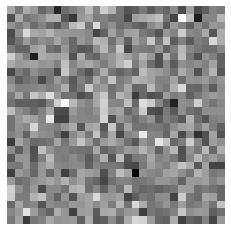

In [14]:
random_z_from_prior = np.random.normal(loc=0, scale=1, size=(1, latent_dim))
generated = decoder.predict(random_z_from_prior)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

The generated image is completely univariate noise: there is no apparent spatial depenedencies between the pixel values. This reflects the lack of prior structure in the randomly initialized fully-connected decoder network. 


Let's now the plug the encoder and decoder via the stochastic latent variable $z$ to get the full VAE architecture. The loss function is the negative ELBO of the variational inference problem:

$$ \underbrace{- \mathbb{E}_{z \sim q_\phi(z|x)}\left[ \mathop{log} p_\theta(x|z) \right]}_{\text{Reconstruction term}} + \underbrace{D_{\mathrm{KL}}\left[q_\phi(z|x) \Vert p(z)\right]}_{\text{Regularization KL term}} $$

**Hint**: The KL-divergence between two gaussians $\mathcal{N}(\mu_1, \sigma_1)$ and $\mathcal{N}(\mu_2,\sigma_2)$ is

$$ D_{\mathrm{KL}}\left[p\Vert q\right] = \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2} $$

*Exercices*

1.   Compute the KL regularization term for a simple gaussian prior
2.   Implement the KL regularization term in the code below
3.   Implement the reconstruction term using the cross-entropy loss


In [15]:
# Exercise :
# * Assemble the VAE using the sampling layer and the loss seen in class

def make_vae(input_shape, encoder, decoder, sampling_layer):
    # Build de model architecture by assembling the encoder,
    # stochastic latent variable and decoder:
    
    ####
    x = Input(shape=input_shape, name="input")
    z_mean, z_log_var = encoder(x)
    z = sampling_layer([z_mean, z_log_var])
    x_decoded_mean = decoder(z)
    vae = Model(x, x_decoded_mean)



    reconstruction_term = original_dim * metrics.binary_crossentropy(
    Flatten()(x), Flatten()(x_decoded_mean))
    regularization_kl_term = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_loss = tf.reduce_mean(reconstruction_term + regularization_kl_term)

   
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = make_vae((original_dim,), encoder, decoder,
               sampling_layer=sampling_layer)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
mlp_encoder (Functional)        [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           mlp_encoder[0][0]                
                                                                 mlp_encoder[0][1]                
__________________________________________________________________________________________________
mlp_decoder (Functional)        (None, 784)          202256      latent_sampler[0][0]         

In [16]:
vae.fit(x_train_standard, epochs=50, batch_size=100,
        validation_data=(x_test_standard, None))

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 313.6082 - val_loss: 290.6754
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 285.4524 - val_loss: 283.1337
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 279.8148 - val_loss: 280.3061
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 276.7977 - val_loss: 276.7452
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 274.7445 - val_loss: 274.7431
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 272.7874 - val_loss: 273.2808
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 271.4131 - val_loss: 273.6003
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 270.4200 - val_loss: 271.9903
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 269.4373 - val_loss: 271.4042
Epoch 10/50
600/600 [==============================] - 2s 3ms/st

Note that the model has not yet converged even after 50 epochs. Furthermore it's is not overfitting significantly either. We chose a very low value for the latent dimension. It is likely that using the higher dimensional space could lead to a model either to optimize that would better fit the training set.

By sampling a random latent vector from the prior distribution and feeding it to the decoder we can effectively sample from the image model trained by the VAE:

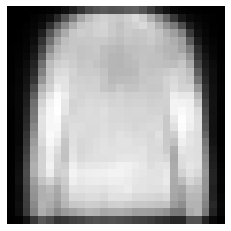

In [17]:
random_z_from_prior = np.random.normal(size=(1, latent_dim)).astype("float32")
generated = decoder(random_z_from_prior).numpy()
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

Run the cell several times to sample from various random locations in the 2D latent space.

The generated pictures are blurry but capture of the global organization of pixels required to represent samples from the 10 fashion item categories. The spatial structure has been learned and is only present in the decoder weights.

### 2D plot of the image classes in the latent space

We can also use the encoder to set the visualize the distribution of the test set in the 2D latent space of the VAE model. In the following the colors show the true class labels from the test samples.

Note that the VAE is an unsupervised model: it did not use any label information during training. However we can observe that the 2D latent space is largely structured around the categories of images used in the training set.

In [25]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

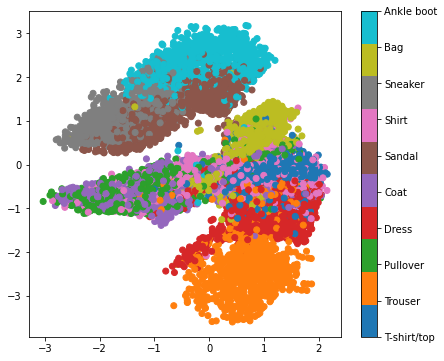

In [26]:
x_test_encoded, _ = encoder(x_test_standard)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

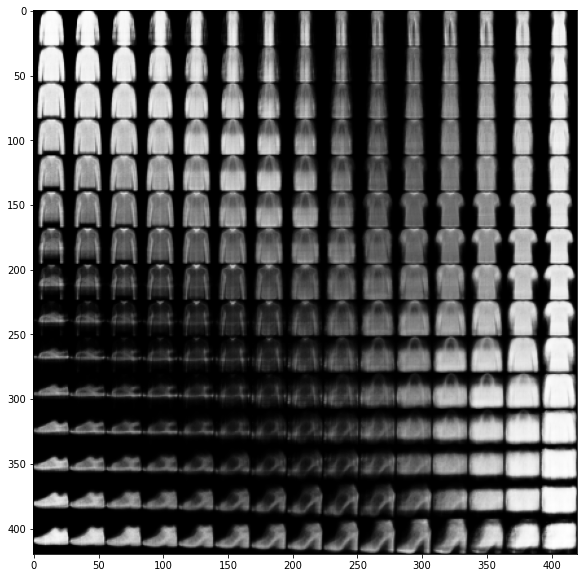

In [27]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder(z_sample).numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

*Exercise* Visualize the latent space 

One can observe that the global 2D shape of the encoded dataset is approximately spherical with values with a maximum radius of size 3. Where can you explain where the shape of this marginal latent distribution come from?

### 2D panel view of samples from the VAE manifold

The following linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z. This makes it possible to use a square arangement of panels that spans the gaussian prior of the latent space.

*Exercise* Visualize the VAE manifold by decoding !

In [32]:
n = 15  # figure with 15x15 panels

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))



## Convolutional Variational Auto Encoder

In [33]:
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)
x_train_conv.shape, x_test_conv.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [34]:
def make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                      spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(filters * spatial_size * spatial_size, activation='relu')(x)
    x = Reshape((spatial_size, spatial_size, filters))(x)
    # First up-sampling:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=(2, 2),
                        activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=1,
                        activation='relu')(x)
    x = BatchNormalization()(x)
    # Second up-sampling:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        strides=(2, 2),
                        padding='valid',
                        activation='relu')(x)
    x = BatchNormalization()(x)
    # Ouput 1 channel of gray pixels values between 0 and 1:
    x = Conv2D(1, kernel_size=2, padding='valid',
               activation='sigmoid')(x)
    return Model(decoder_input, x, name='convolutional_decoder')
conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                                 spatial_size=7, filters=filters)
print(conv_decoder.summary())
from tensorflow.keras.layers import BatchNormalization
img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2
def make_conv_encoder(img_rows, img_cols, img_chns,
                      latent_dim, intermediate_dim):
    inp = Input(shape=(img_rows, img_cols, img_chns))
    x = Conv2D(
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        padding='same',
        activation='relu',
        strides=(2,2)
    )(inp)
    x = BatchNormalization()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        padding='same',
        activation='relu',
        strides=(2,2)
    )(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(units=intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    return Model(inputs=inp, outputs=[z_mean, z_log_var],
                 name='convolutional_encoder')
conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns,
                                 latent_dim, intermediate_dim)
print(conv_encoder.summary())


Model: "convolutional_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_22 (Dense)             (None, 1568)              202272    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 3

In [22]:
#@title **Exercise**: write an encoder that uses a series of convolutional layers, with maxpooling or strided convolutions and Batch norm to encode the 2D, gray-level images into 2D latent vectors { display-mode: "form" }
from tensorflow.keras.layers import BatchNormalization

img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2


def make_conv_encoder(img_rows, img_cols, img_chns,
                      latent_dim, intermediate_dim):
    inp = Input(shape=(img_rows, img_cols, img_chns))
    x = Conv2D(
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        padding='same',
        activation='relu',
        strides=(2,2)
    )(inp)
    x = BatchNormalization()(x)

    x = Conv2D(
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        padding='same',
        activation='relu',
        strides=(2,2)
    )(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(units=intermediate_dim, activation='relu')(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    return Model(inputs=inp, outputs=[z_mean, z_log_var],
                 name='convolutional_encoder')


conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns,
                                 latent_dim, intermediate_dim)
print(conv_encoder.summary())

Model: "convolutional_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 32)     9248        batch_normalization[0][0]        
______________________________________________________________________________

In [35]:
from tensorflow.keras.layers import BatchNormalization

img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2


def make_conv_encoder(img_rows, img_cols, img_chns,
                      latent_dim, intermediate_dim):
    inp = Input(shape=(img_rows, img_cols, img_chns))

    ...
    
    z_mean = ...
    z_log_var = ...

    return Model(inputs=inp, outputs=[z_mean, z_log_var],
                 name='convolutional_encoder')


conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns,
                                 latent_dim, intermediate_dim)
print(conv_encoder.summary())

ValueError: ignored

The stochastic latent variable is the same as for the fully-connected model.

In [36]:
sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

## Decoder

The decoder is also convolutional but instead of downsampling the spatial dimensions from (28, 28) to 2 latent dimensions, it starts from the latent space to upsample a (28, 28) dimensions using strided `Conv2DTranspose` layers.

Here again BatchNormalization layers are inserted after the convolution to make optimization converge faster.

In [ ]:
#@title Exercise: write a decoder using inverse convolution
def make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                      spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(filters * spatial_size * spatial_size, activation='relu')(x)
    x = Reshape((spatial_size, spatial_size, filters))(x)
    # First up-sampling:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=(2, 2),
                        activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=1,
                        activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Second up-sampling:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        strides=(2, 2),
                        padding='valid',
                        activation='relu')(x)
    x = BatchNormalization()(x)
    # Ouput 1 channel of gray pixels values between 0 and 1:
    x = Conv2D(1, kernel_size=2, padding='valid',
               activation='sigmoid')(x)
    return Model(decoder_input, x, name='convolutional_decoder')


conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                                 spatial_size=7, filters=filters)
print(conv_decoder.summary())

In [ ]:
def make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                      spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    
    ...

    return Model(decoder_input, x, name='convolutional_decoder')


conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                                 spatial_size=7, filters=filters)
print(conv_decoder.summary())

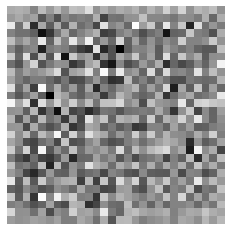

In [37]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

This new decoder encodes some a priori knowledge on the local dependencies between pixel values in the "deconv" architectures. Depending on the randomly initialized weights, the generated images can show some local spatial structure.

Try to re-execute the above two cells several times to try to see the kind of local structure that stem from the "deconv" architecture it-self for different random initializations of the weights.


Again, let's now plug everything to together to get convolutional version of a full VAE model:

In [38]:
input_shape = (img_rows, img_cols, img_chns)
vae = make_vae(input_shape, conv_encoder, conv_decoder,
               sampling_layer)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
convolutional_encoder (Function [(None, 2), (None, 2 211172      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           convolutional_encoder[0][0]      
                                                                 convolutional_encoder[0][1]      
__________________________________________________________________________________________________
convolutional_decoder (Function (None, 28, 28, 1)    230913      latent_sampler[0][0]       

In [39]:
vae.fit(x_train_conv, epochs=15, batch_size=100,
        validation_data=(x_test_conv, None))

Epoch 1/15
600/600 [==============================] - 6s 7ms/step - loss: 286.5212 - val_loss: 286.9799
Epoch 2/15
600/600 [==============================] - 4s 7ms/step - loss: 266.6018 - val_loss: 266.0703
Epoch 3/15
600/600 [==============================] - 4s 7ms/step - loss: 264.0653 - val_loss: 264.5124
Epoch 4/15
600/600 [==============================] - 4s 7ms/step - loss: 263.0627 - val_loss: 263.4566
Epoch 5/15
600/600 [==============================] - 4s 7ms/step - loss: 261.8125 - val_loss: 263.9940
Epoch 6/15
600/600 [==============================] - 4s 7ms/step - loss: 261.0907 - val_loss: 262.3839
Epoch 7/15
600/600 [==============================] - 4s 7ms/step - loss: 260.3917 - val_loss: 261.3289
Epoch 8/15
600/600 [==============================] - 4s 7ms/step - loss: 259.8818 - val_loss: 261.4351
Epoch 9/15
600/600 [==============================] - 4s 7ms/step - loss: 259.3492 - val_loss: 261.1626
Epoch 10/15
600/600 [==============================] - 4s 7ms/st

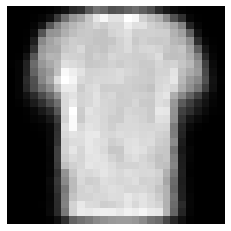

In [40]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

### 2D plot of the image classes in the latent space

We find again a similar organization of the latent space. Compared to the fully-connected VAE space, the differnt class labels seem slightly better separated. This could be a consequence of the slightly better fit we obtain from the convolutional models.

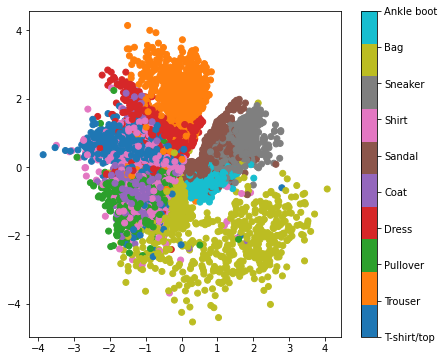

In [41]:
x_test_encoded, _ = conv_encoder(x_test_conv)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

### 2D panel view of samples from the VAE manifold

The following linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z. This makes it possible to use a square arangement of panels that spans the gaussian prior of the latent space.

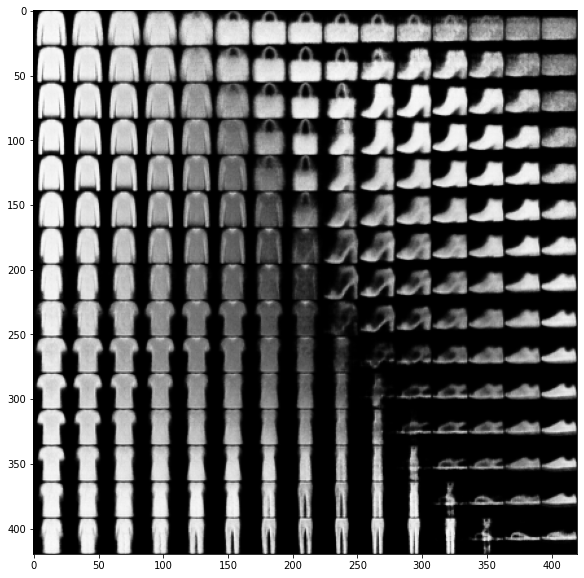

In [42]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = conv_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()